<a href="https://colab.research.google.com/github/ktyptorio/WoC-Analytics-Team/blob/main/Kertas_Kerja_ASN_BSSN_WoC_Analytics_Team.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

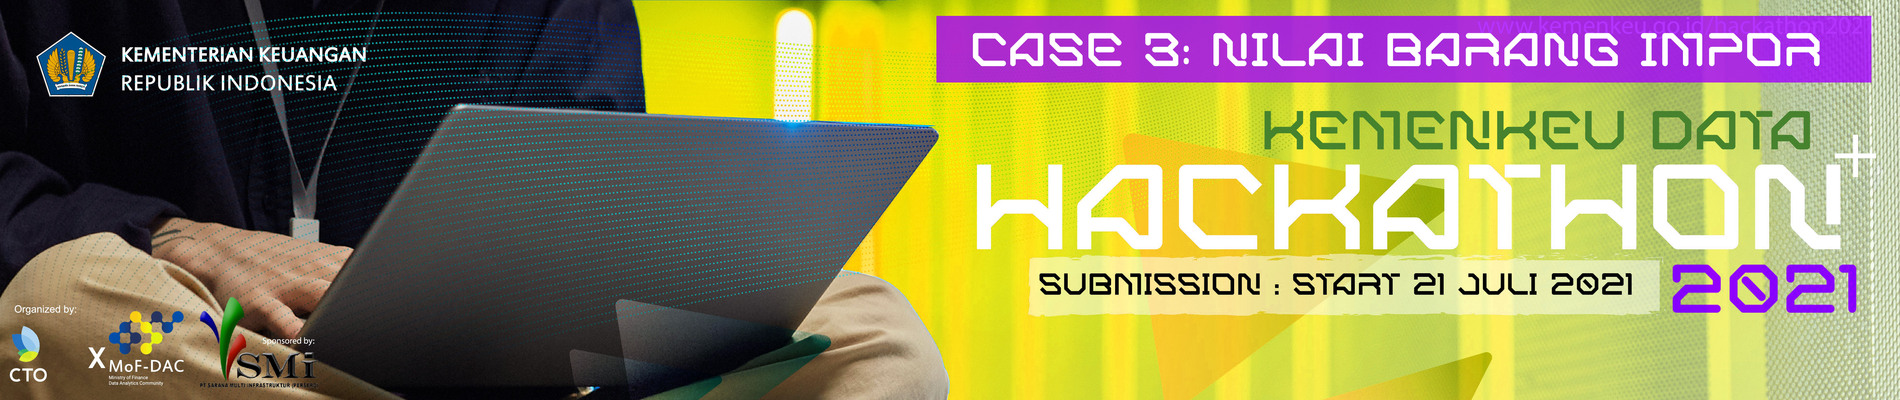

WoC Analytics Team
1. Caesario Oktanto Kisty
2. Egi Anggriawan
3. Fajar Dimar Habibi

Studi Kasus: Regresi

Tujuan: Memprediksi harga barang yang diimpor

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
path = "/content/drive/MyDrive/train_case3.txt"
path1 = "/content/drive/MyDrive/test_case3.txt"
dataset = pd.read_csv(path, sep=('|'))
datates = pd.read_csv(path1, sep=('|'))

# Data Cleansing

In [ ]:
dataset

In [ ]:
aggregasi = dataset.groupby('KODE_BARANG').count().reset_index().sort_values('KODE_BARANG')
aggregasi2 = datates.groupby('KODE_BARANG').count().reset_index().sort_values('KODE_BARANG')

In [ ]:
fig = plt.figure(figsize = (20, 10))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

addlabels(aggregasi['KODE_BARANG'].astype(str),aggregasi['id'])

def addlabels2(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]*4.5, y[i], ha = 'center')

addlabels2(aggregasi2['KODE_BARANG'].astype(str),aggregasi2['id'])

plt.bar(aggregasi['KODE_BARANG'].astype(str), aggregasi['id'], color = 'aqua')
plt.bar(aggregasi2['KODE_BARANG'].astype(str), aggregasi2['id'], bottom = aggregasi['id'], color = 'aquamarine')
plt.xlabel("KODE_BARANG")
plt.ylabel("Jumlah Barang")
plt.legend(labels=['Data Train', 'Data Test'])
plt.show()

In [ ]:
aggregasi2 = datates.groupby('KODE_BARANG').count().reset_index().sort_values('KODE_BARANG')

In [ ]:
fig = plt.figure(figsize = (20, 10))

# function to add value labels
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

addlabels(aggregasi2['KODE_BARANG'].astype(str),aggregasi2['id'])

plt.bar(aggregasi2['KODE_BARANG'].astype(str),aggregasi2['id'])
plt.xlabel("KODE_BARANG")
plt.ylabel("Jumlah Barang")
plt.show()

In [ ]:
dataset['KODE_BARANG'].unique()

In [ ]:
dataset['JUMLAH_BARANG'].describe().astype(int)

In [ ]:
sentences = ['(BARU)', 'BARANG BARU', 'BAIK & BARU', 'BAIK DAN BARU', '(BAIK/BARU)', 'BAIK/BARU', 'KEADAAN BARU', ',', 'BAIK', '(', ')']
df1 = pd.DataFrame({'Sentences': sentences})
dataset['Text_cleaned'] = dataset.DESKRIPSI_BARANG.str.replace('|'.join(df1.Sentences), '')
datates['Text_cleaned'] = datates.DESKRIPSI_BARANG.str.replace('|'.join(df1.Sentences), '')
dataset01 = dataset
datates01 = datates

In [ ]:
pd.DataFrame(dataset01['DESKRIPSI_BARANG'])

In [ ]:
pd.DataFrame(dataset01['Text_cleaned'])

In [ ]:
import nltk
import string
import re

temp0 = []
temp1 = []

for i in range(len(dataset01)):
  temp = dataset01['Text_cleaned'][i].translate(str.maketrans("","",string.punctuation))
  temp0.append(len(temp.split()))
  temp1.append(temp)

dataset01['token'] = temp0
dataset01['Text_cleaned'] = temp1

In [ ]:
pd.DataFrame(dataset01['Text_cleaned']).head(30)

In [ ]:
import nltk
import string
import re

temp0 = []
temp1 = []

for i in range(len(datates01)):
  temp = datates01['Text_cleaned'][i].translate(str.maketrans("","",string.punctuation))
  temp0.append(len(temp.split()))
  temp1.append(temp)

datates01['token'] = temp0
datates01['Text_cleaned'] = temp1

In [ ]:
dataset01[dataset01['KODE_BARANG'] == 4016991400].groupby(['Text_cleaned','ASAL_BARANG','JUMLAH_KEMASAN','JENIS_KEMASAN','KODE_SATUAN_BARANG','JUMLAH_BARANG','MENGGUNAKAN_FASILITAS','HARGA_BARANG_IDRt']).count().reset_index().sort_values('id')

# Build Model and Prediction

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor, AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, accuracy_score, f1_score, mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
import lightgbm as lgb

In [ ]:
preds0 = []
id0 = []
kode = [4016991400, 7318150000, 8708997000, 3926909900, 4009429000,
       8714109090, 8708999000, 9401903900, 9503009900]

for i in kode:
  dataset011 = dataset01[(dataset01['KODE_BARANG'] == i)]
  datates011 = datates01[(datates01['KODE_BARANG'] == i)]

  y = dataset011.HARGA_BARANG_IDR
  X = dataset011.drop(['HARGA_BARANG_IDR','id'], axis=1)
  X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

  class ColumnSelector(BaseEstimator, TransformerMixin):
      """Select only specified columns."""
      def __init__(self, columns):
          self.columns = columns
          
      def fit(self, X, y=None):
          return self
      
      def transform(self, X):
          return X[self.columns]

  categorical_cols = ['ASAL_BARANG', 'JENIS_KEMASAN','KODE_SATUAN_BARANG', 'MENGGUNAKAN_FASILITAS']
  text_cols = 'Text_cleaned'
  numerical_cols = ['JUMLAH_BARANG','JUMLAH_KEMASAN', 'token']

  numerical_transformer = Pipeline(steps=[
      ('selector', ColumnSelector(numerical_cols)),
      ('scaler', StandardScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('selector', ColumnSelector(categorical_cols)),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  text_transformer = Pipeline(steps=[
      ('selector', ColumnSelector(text_cols)),
      ('vectorizer02' , CountVectorizer(analyzer='word'))
  ])

  preprocessor = FeatureUnion(
      transformer_list=[
          ('num', numerical_transformer),
          ('cat', categorical_transformer),
          ('txt', text_transformer)
      ])

  hyper_params = {
      'boosting_type': 'gbdt',
      'objective': 'regression',
      'learning_rate': 0.1,
      "max_depth": -1,
      "num_leaves": 256,  
      "max_bin": 512,
      "n_estimators": 1500
  }

  model = lgb.LGBMRegressor(**hyper_params)

  reg = Pipeline(steps=[
                        ('preprocessor',preprocessor),
                        ('model' , model)
                      ])
  scores = cross_val_score(reg, X, y, cv=5, scoring='neg_root_mean_squared_error')
  print(scores)


  # reg.fit(X_train, y_train)

  # preds = reg.predict(X_valid)
  
  # acccuracy =   mean_squared_error(y_valid, preds)

  # preds0.append(preds)
  # id0.append(datates011['id'])

  # print(i)

# Data Prediction Preparation

In [ ]:
preds1 = pd.DataFrame(preds0[0])
for i in range(8):
  preds1 = pd.concat([preds1,pd.DataFrame(preds0[i+1])])

id1 = id0[0]
for i in range(8):
  id1 = pd.concat([id1,id0[i+1]])

In [ ]:
preds1.columns = ['HARGA_BARANG_IDR']
preds1.reset_index(inplace=True)
del preds1['index']

id1 = pd.DataFrame(id1)
id1.columns = ['id']
id1.reset_index(inplace=True)
del id1['index']

hasil_datates = pd.concat([id1,preds1], axis=1)
gabung = pd.merge(datates, hasil_datates, on='id', how='inner')

In [ ]:
output_lengkap = pd.DataFrame({'id': gabung['id'],
                       'HARGA_BARANG_IDR': gabung['HARGA_BARANG_IDR']})
# output
output_lengkap.to_csv('Submission_WOC.csv', index=False)